In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('images') if isfile(join('images', f))]

In [3]:
image_path = 'images/EAN-UPC-EAN-13 MASTER GRADE IMGB.bmp' # C39_4.4LOW  C39_7.5UP  EAN128-DEFECTS IMGB  EAN128-MASTER IMGB  EAN-UPC-EAN-13 MASTER GRADE IMGB

In [4]:
image_path = f'images/{images_paths[10]}'#'other images/1.png'#f'images/{images_paths[22]}'

(1024, 1280, 3)


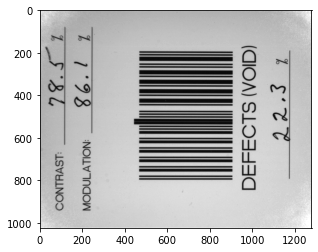

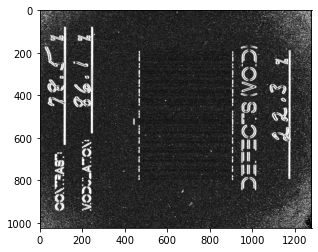

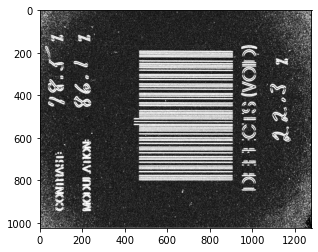

In [5]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')

# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(cv2.convertScaleAbs(gradX), 'gray')

plt.figure()
plt.imshow(cv2.convertScaleAbs(gradY), 'gray')

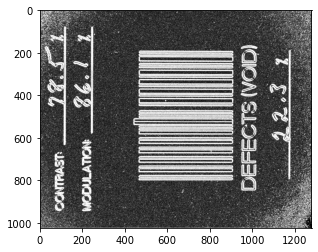

In [8]:
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradY, gradX)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')

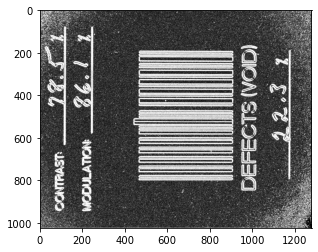

In [9]:
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')

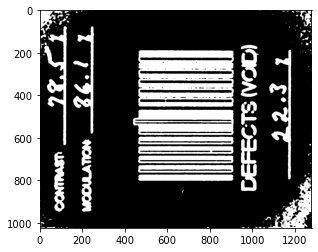

In [10]:
# Threshold, Otsu's algorithm
blurred = cv2.blur(gradient, (9, 9))
ret2,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#thresh = 255-thresh

plt.figure()
plt.imshow(thresh, 'gray')

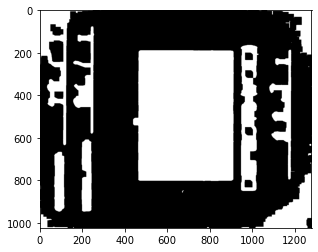

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

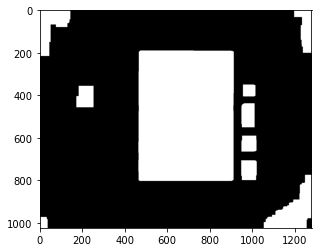

In [12]:
# Remove things outside
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')

#opened1 = closed

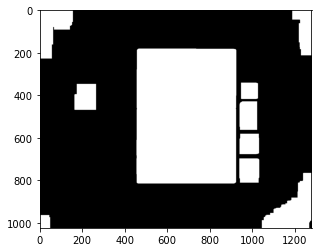

In [13]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
dilated = cv2.dilate(opened, kernel, iterations = 3)#cv2.dilate(opened1, kernel, iterations = 5)

plt.figure()
plt.imshow(dilated, 'gray')

((688.5191650390625, 497.7236022949219), (468.4850158691406, 633.6687622070312), 0.14077559113502502)
[[453 813]
 [455 180]
 [923 181]
 [921 815]]


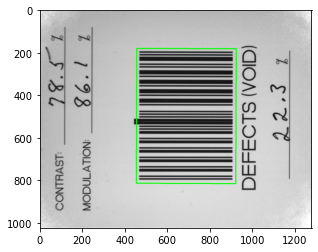

In [14]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
print(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

[(455.0, 180.0), (923.0, 181.0), (453.0, 813.0), (921.0, 815.0)]
[[453. 813.]
 [180. 455.]
 [181. 923.]
 [815. 921.]]


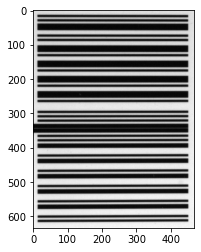

In [15]:
h = 1024
w = 1280

coordinates_source = box.astype('float32')
print(sorted([tuple(v) for v in coordinates_source], key=lambda t: (t[1],t[0])))
print(np.sort(coordinates_source))

min_width = coordinates_source[:,0].min()
min_height = coordinates_source[:,1].min()
max_width = coordinates_source[:,0].max()
max_height = coordinates_source[:,1].max()
def normalize(value, axis=0):
    if axis==0:  # Horizontal dimension
        return min_width if (value-min_width<max_width-value) \
                         else max_width
    elif axis==1:  # Vertical dimension
        return min_height if (value-min_height<max_height-value) \
                          else max_height
coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                            normalize(t[0], axis=0))))

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
coordinates_destination = np.array([[0, 0],
                                    [destination_width-1, 0],
                                    [0, destination_height-1],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')

In [18]:
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray1, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray1, ddepth=ddepth, dx=0, dy=1, ksize=-1)

In [21]:
gradX.sum()

244827.0

In [19]:
cv2.convertScaleAbs(gradX).sum()

8366586

In [22]:
gradY.sum()

294203.0

In [20]:
cv2.convertScaleAbs(gradY).sum()

43034129

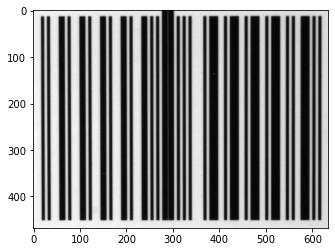

In [25]:
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray1, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray1, ddepth=ddepth, dx=0, dy=1, ksize=-1)
if cv2.convertScaleAbs(gradY).sum()>cv2.convertScaleAbs(gradX).sum():
    destination_height_rot, destination_width_rot = destination_width, destination_height
    coordinates_destination_rot = np.array([[destination_width_rot-1, 0],
                                            [destination_width_rot-1, destination_height_rot-1],
                                            [0, 0],                                        
                                            [0, destination_height_rot-1]], dtype='float32')

    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_destination, coordinates_destination_rot)

    # Applying the trasformation
    gray1_rot = cv2.warpPerspective(gray1, H, (destination_width_rot, destination_height_rot))

    plt.imshow(gray1_rot, 'gray')